In [16]:
%pip install opencv-python

In [17]:
#                               virtualEnv : myEnv
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, callbacks
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [18]:
def load_images(data_dir, image_size=(224, 224)):
    images = []
    labels = []
    class_names = ['cancer', 'non_cancer']
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            # print(img_path)
            image = cv2.imread(img_path)
            image = cv2.resize(image, image_size)
            images.append(image)
            labels.append(class_names.index(class_name))
    return np.array(images), np.array(labels)

data_dir = '../oc_datasets/final_dataset/complete_dsm'
os.listdir(data_dir)
images, labels = load_images(data_dir)
images = images / 255.0  



In [19]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)


In [20]:
def conv3x3(filters, stride=1):
    return layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)

def basic_block(x, filters, stride=1):
    identity = x
    if stride != 1 or x.shape[-1] != filters:
        identity = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', use_bias=False)(x)
        identity = layers.BatchNormalization()(identity)
    
    x = conv3x3(filters, stride)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = conv3x3(filters)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Add()([x, identity])
    x = layers.ReLU()(x)
    return x


In [21]:
def hrnet(input_shape=(224, 224, 3), num_classes=2):
    inputs = layers.Input(shape=input_shape)
    x = conv3x3(64)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Stage 1
    x = basic_block(x, 64)
    x = basic_block(x, 64)
    
    # Stage 2
    x = basic_block(x, 128, stride=2)
    x = basic_block(x, 128)
    
    # Stage 3
    x = basic_block(x, 256, stride=2)
    x = basic_block(x, 256)
    
    # Stage 4
    x = basic_block(x, 512, stride=2)
    x = basic_block(x, 512)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model


In [22]:
model = hrnet()
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [23]:
# Data Augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

checkpoint = callbacks.ModelCheckpoint('hrnet_best_model.keras', save_best_only=True, monitor='val_loss')
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [24]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 224, 224,  │      1,728 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_34 (ReLU)     │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 224, 224,  │     36,864 │ re_lu_34[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_35 (ReLU)     │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 224, 224,  │     36,864 │ re_lu_35[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ re_lu_34[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_36 (ReLU)     │ (None, 224, 224,  │          0 │ add_16[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 224, 224,  │     36,864 │ re_lu_36[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_37 (ReLU)     │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 224, 224,  │     36,864 │ re_lu_37[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_44[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 224, 224,  │          0 │ batch_normalizat

 Total params: 11,442,114 (43.65 MB)

 Trainable params: 11,432,514 (43.61 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [15]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=32,
                    callbacks=[checkpoint, early_stopping])


Epoch 1/32


c:\Users\Mudasir\anaconda3\envs\myEnv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 323s 13s/step - accuracy: 0.5190 - loss: 1.0028 - val_accuracy: 0.5402 - val_loss: 17.2441
Epoch 2/32
22/22 ━━━━━━━━━━━━━━━━━━━━ 296s 13s/step - accuracy: 0.5976 - loss: 0.6986 - val_accuracy: 0.5402 - val_loss: 5.1355
Epoch 3/32
22/22 ━━━━━━━━━━━━━━━━━━━━ 294s 13s/step - accuracy: 0.5884 - loss: 0.6840 - val_accuracy: 0.5057 - val_loss: 0.7049
Epoch 4/32
22/22 ━━━━━━━━━━━━━━━━━━━━ 302s 14s/step - accuracy: 0.6267 - loss: 0.6490 - val_accuracy: 0.5632 - val_loss: 0.7323
Epoch 5/32
22/22 ━━━━━━━━━━━━━━━━━━━━ 303s 14s/step - accuracy: 0.6119 - loss: 0.6461 - val_accuracy: 0.4885 - val_loss: 0.7455
Epoch 6/32
22/22 ━━━━━━━━━━━━━━━━━━━━ 302s 14s/step - accuracy: 0.6450 - loss: 0.6249 - val_accuracy: 0.5575 - val_loss: 0.6881
Epoch 7/32
22/22 ━━━━━━━━━━━━━━━━━━━━ 294s 13s/step - accuracy: 0.6326 - loss: 0.6358 - val_accuracy: 0.5632 - val_loss: 0.7326
Epoch 8/32
22/22 ━━━━━━━━━━━━━━━━━━━━ 296s 13s/step - accuracy: 0.6553 - loss: 0.6164 - val_accuracy: 0.5460 - val

In [26]:
# Load the best model
best_model = tf.keras.models.load_model('hrnet_best_model.keras')

# Evaluate the model
val_predictions = best_model.predict(X_val)
val_predictions = np.argmax(val_predictions, axis=1)

print(classification_report(y_val, val_predictions, target_names=['cancer', 'non_cancer']))


6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step
              precision    recall  f1-score   support

      cancer       0.64      0.56      0.60        94
  non_cancer       0.55      0.62      0.58        80

    accuracy                           0.59       174
   macro avg       0.59      0.59      0.59       174
weighted avg       0.60      0.59      0.59       174



SAVING MODEL

In [ ]:
# model.save('hrnet_trained_model.keras') ---------------------> not SAVED NEXT TIME SAVE THE MODEL 

In [27]:
import matplotlib.pyplot as plt

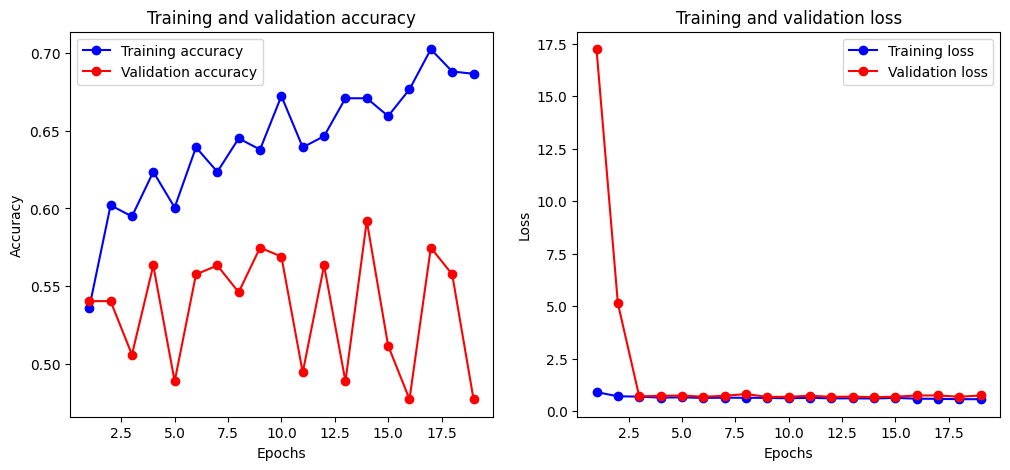

In [28]:

def plot_history(history):
    # Extract values
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    # Plot training and validation accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

# Call the plot_history function
plot_history(history)

In [29]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

<Figure size 800x600 with 0 Axes>

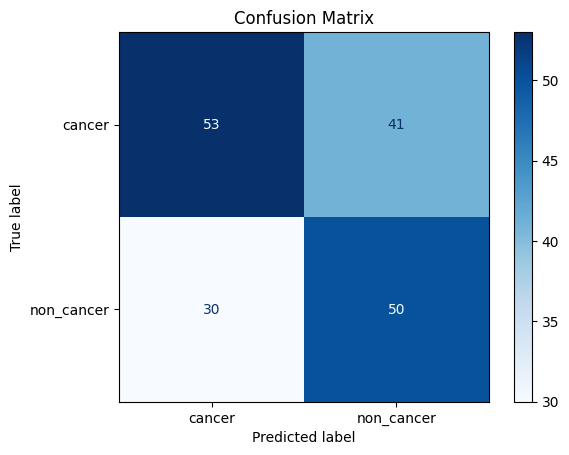

In [30]:
cm = confusion_matrix(y_val, val_predictions)

# Plot the confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Call the function to plot the confusion matrix
plot_confusion_matrix(cm, class_names=['cancer', 'non_cancer'])

In [1]:
from flask import Flask, redirect, url_for, request, render_template

In [6]:
model = tf.keras.models.load_model('hrnet_best_model.keras')

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img


def classify_image(image_path):
    img = preprocess_image(image_path)
    predictions = model.predict(img)
    class_idx = np.argmax(predictions, axis=1)[0]
    class_names = ['cancer', 'non_cancer']
    return class_names[class_idx]

app.py file

html file

In [ ]:
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Oral Cancer Detection</title>
</head>
<body>
    <h1>Upload an Image to Detect Oral Cancer</h1>
    <form action="/" method="post" enctype="multipart/form-data">
        <input type="file" name="file" accept="image/*">
        <input type="submit" value="Upload">
    </form>
</body>
</html>


result file

In [ ]:
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Oral Cancer Detection Result</title>
</head>
<body>
    <h1>Result</h1>
    <p>Classification: {{ result }}</p>
    <img src="{{ url_for('display_image', filename=filename) }}" alt="Uploaded Image">
    <br>
    <a href="{{ url_for('upload_file') }}">Upload another image</a>
</body>
</html>